In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import eigh, expm, ishermitian

import seaborn as sns
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer

np.random.seed(9112001)
np.set_printoptions(precision=5)

In [2]:
def get_itimevol_circuit(N, M, H, t, psi_0):
    n_anc = 2 * M
    

    anc_idxs = list(range(n_anc))
    sys_idxs = list(range(n_anc, n_anc + N))
    alpha    = 2 * np.arctan(np.sqrt(0.5))
    beta     = 0.5 * np.pi
    gamma    = -1.5 * np.pi
    anc      = QuantumRegister(n_anc, name="a")
    syst     = QuantumRegister(N, name="q")
    qc       = QuantumCircuit(anc, syst)

    qc.initialize(psi_0, sys_idxs)

    for i in range(2 * M - 1, 0, -2): 
        # setup gates for ancillary qubits
        qc.ry(alpha, i - 1)
        qc.ry(beta, i)
        qc.cx(i - 1, i, ctrl_state = 0)
        qc.crz(gamma, control_qubit = i - 1, target_qubit = i)

        U_1    = expm(1j * H * t / M)
        U_1_op = UnitaryGate(U_1, label="U(-t/M)").control(1)
        qc.append(U_1_op, [i - 1] + sys_idxs) # control on qubit i - 1 and act on the system qubits

        U_2    = expm(-2j * H * t / M)
        U_2_op = UnitaryGate(U_2, label="U(2t/M)").control(2)
        qc.append(U_2_op, [i - 1, i] + sys_idxs) # control on qubits i - 1 and i and act on the system qubits

    # setup measurement qubits
    qc.h(anc_idxs)

    return qc

In [3]:
# consider 3 qubits
N   = 3
N_h = 2 ** N
t   = 1

""" Build A matrix such that the Hamiltoninan has
    entries with both real and imaginary part 
    inside (-bound, bound)
"""
bound = 3
A = 0.5 * (2 * bound * np.random.rand(N_h, N_h) + 2 * bound * 1j * np.random.rand(N_h, N_h) - bound) 
# A = np.random.rand(N_q, N_q) + 1j * np.random.rand(N_q, N_q) - 1
H = A + A.conj().T
print("Hermeticity check: ", ishermitian(H))
print(np.matrix(H[:1]))

evs, w = eigh(H)
w      = w.T
gs     = w[0] / np.linalg.norm(w[0]) # we need to normalize it because later we calculate eps
w_max  = w[np.argmax(np.abs(evs))] # select eigenvector that corresponds to the eigenvalue of maximum module

v_min = np.min(np.abs(evs))
v_max = np.max(np.abs(evs))
print(f"Smallest eigenvalue: {evs[0]:.5f}")
print(f"Biggest eigenvalue: {evs[-1]:.5f}")
print(f"Smallest eigenvalue in magnitude v_min = {v_min:.5f}")
print(f"Biggest eigenvalue in magnitude v_max = {v_max:.5f}")

Hermeticity check:  True
[[-2.1912 +0.j       2.23333-0.18609j  0.18298-0.18018j -0.9957 -1.09025j
   0.75113-1.26424j  1.38166+1.66049j  0.06276-0.22045j -0.21587-1.02466j]]
Smallest eigenvalue: -7.62019
Biggest eigenvalue: 6.88190
Smallest eigenvalue in magnitude v_min = 0.35586
Biggest eigenvalue in magnitude v_max = 7.62019


In [4]:
M_max    = 4
M_values = np.arange(1, M_max + 1)
n_points = 6
a_values = np.linspace(0, 1, n_points)

data = []

for M in M_values:
    print(f"M = {M}     eval * t / M: {evs * t / M}")
    
    for a_0 in a_values:
        n_anc = 2 * M
        psi_0 = a_0 * gs + np.sqrt(1 - a_0 ** 2) * w[1]
        psi_0 /= np.linalg.norm(psi_0)

        qc = get_itimevol_circuit(N, M, H, t, psi_0)
        qc.save_statevector()

        aer_sim = Aer.get_backend("aer_simulator_statevector_gpu")
        qc_tp   = transpile(qc, backend=aer_sim)
        result  = aer_sim.run(qc_tp).result()

        final_state_dict     = result.get_statevector(qc_tp).to_dict()
        final_state_sys_dict = {}

        for k, v in final_state_dict.items():
            if k[-n_anc:] == '0' * n_anc:
                k_new = k[:N]
                final_state_sys_dict[k_new] = v

        final_state_sys_list = sorted(final_state_sys_dict.items())
        final_state          = np.array([t[1] for t in final_state_sys_list])
        final_state          /= np.linalg.norm(final_state)

        # print(f"Normalization check: ||gs|| = {np.linalg.norm(gs)}      ||final_state|| = {np.linalg.norm(final_state)}")
        eps = 1 - np.abs(np.vdot(gs, final_state)) ** 2
        data.append((M, a_0, eps))

M = 1     eval * t / M: [-7.62019 -4.58636 -2.54718 -0.83373  0.35586  2.39583  4.1434   6.8819 ]
M = 2     eval * t / M: [-3.81009 -2.29318 -1.27359 -0.41686  0.17793  1.19791  2.0717   3.44095]
M = 3     eval * t / M: [-2.54006 -1.52879 -0.84906 -0.27791  0.11862  0.79861  1.38113  2.29397]
M = 4     eval * t / M: [-1.90505 -1.14659 -0.63679 -0.20843  0.08896  0.59896  1.03585  1.72048]


    M  a_0           eps
0   1  0.0  1.000000e+00
1   1  0.2  8.041078e-01
2   1  0.4  4.731117e-01
3   1  0.6  2.331658e-01
4   1  0.8  8.776384e-02
5   1  1.0 -4.440892e-16
6   2  0.0  1.000000e+00
7   2  0.2  9.932870e-01
8   2  0.4  9.700307e-01
9   2  0.6  9.163909e-01
10  2  0.8  7.761834e-01
11  2  1.0  0.000000e+00
12  3  0.0  1.000000e+00
13  3  0.2  9.135446e-01
14  3  0.4  6.980180e-01
15  3  0.6  4.390579e-01
16  3  0.8  1.984970e-01
17  3  1.0  0.000000e+00
18  4  0.0  1.000000e+00
19  4  0.2  7.354919e-01
20  4  0.4  3.782087e-01
21  4  0.6  1.707924e-01
22  4  0.8  6.118305e-02
23  4  1.0 -4.440892e-16


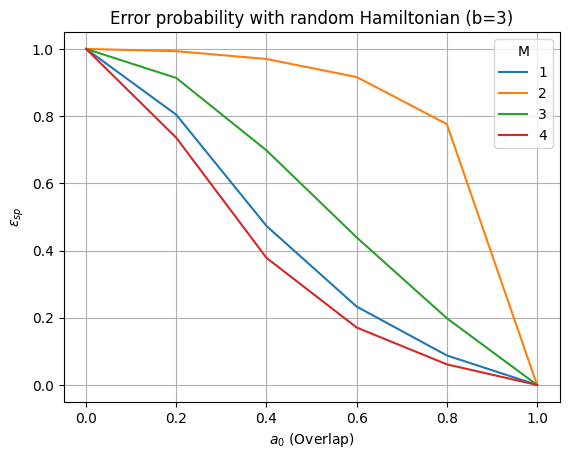

In [8]:
df = pd.DataFrame(data, columns=["M", "a_0", "eps"])
print(df)
sns.lineplot(df, x = "a_0", y = "eps", hue = "M", palette="tab10")
plt.xlabel(r'$a_0$ (Overlap)')
plt.ylabel(r'$\epsilon_{sp}$')
plt.title(f"Error probability with random Hamiltonian (b={bound})")
plt.grid()